<a href="https://colab.research.google.com/github/issa-project/issa-pipeline/blob/main/notebooks/issa-entity-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Named Entities in ISSA dataset

**Analysing quality of named entities found in the document text**  

Use case: Agritrop ISSA

Endpoint: https://data-issa.cirad.fr/sparql

In [2]:
import os
try:
    isColab = os.environ['GCE_METADATA_TIMEOUT']
    if isColab:
        !pip install SPARQLWrapper
except:
    pass

In [43]:
import pandas as pd
import json

from SPARQLWrapper import SPARQLWrapper, JSON

import matplotlib.pyplot as plt

import time

In [93]:
def sparql_service_to_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

def sparql_service_to_dataframe_with_scrollable_cursor(service, query_templ, params=(), page_size=10000):
    offset= 0
    keep_going=True
    df_res_list = [] 

    print('fetching... ', end='')
    try:
        while True:
            query = query_templ % (params + (offset, page_size) )
            df_res = sparql_service_to_dataframe(service, query )
            if df_res.shape[0] > 0 : 
                print(df_res.shape[0], end=', ')
                df_res_list.append(df_res)
                offset = offset + page_size
                time.sleep(5)
            else:
                print(df_res.shape[0])
                break
    except Exception as ex:
        print(ex)
    finally:
        
        return pd.concat(df_res_list) if df_res_list else pd.DataFrame()

def hyperlink(val):
    return '<a href="{}">{}</a>'.format(val,val)

def hyperlink_multi(val):
    uris = val.split(', ')
    uris_hl = ['<a href="{}">{}</a>'.format(v,v) for v in uris]

    return ', '.join(uris_hl)

In [5]:
issa_agritrop_endpoint = 'http://data-issa.cirad.fr/sparql'

## Dataset info

In [6]:
dataset_info_query = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX void:   <http://rdfs.org/ns/void#> 
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>

SELECT * WHERE {
  issa:issa-agritrop dct:title ?dataset_name;
                     dct:description ?dataset_description;
                     void:triples ?triple_count;
                     owl:versionInfo ?version;
                     dct:issued ?initial_date;
                     prov:wasGeneratedAtTime ?generated_date.
  
  OPTIONAL{   issa:issa-agritrop dct:modified ?updated_date. }
} 
'''
dataset_info = sparql_service_to_dataframe(issa_agritrop_endpoint, dataset_info_query)
dataset_info.transpose()

,0
dataset_name,ISSA Agritrop dataset
dataset_description,This RDF dataset was produced by processing ar...
triple_count,175028065
version,1.2.20230406
initial_date,2022-04-29
generated_date,2023-04-05
updated_date,2023-04-05


## Count named entities from all NER tools

In [7]:
entity_count_per_annotator_query = '''
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>


SELECT ?annotator 
       (count(?entity) as ?cnt) 
	     (count(distinct ?uri) as ?unique_cnt)
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
WHERE {
	?entity a prov:Entity;
          oa:hasBody ?uri;
          prov:wasAttributedTo ?annotator.
}
'''

In [8]:
df_entity_count = sparql_service_to_dataframe(issa_agritrop_endpoint, entity_count_per_annotator_query)

df_entity_count = df_entity_count.astype({'cnt': 'int',
                                          'unique_cnt' : 'int'})

print(df_entity_count.shape)

(4, 3)


In [9]:
table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
df_entity_count.style.set_table_styles(table_style)

,annotator,cnt,unique_cnt
0,http://data-issa.cirad.fr/DBPediaSpotlight,1837170,72546
1,http://data-issa.cirad.fr/EntityFishing,4513332,142926
2,http://data-issa.cirad.fr/GeographicEntityExtractor,249182,12075
3,http://data-issa.cirad.fr/Pyclinrec,3587889,17397


In [10]:
annotations_per_entity_count_query = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <http://data-issa.cirad.fr/property/> 

SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {

      SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
      WHERE {

      {
      SELECT ?uri ?annotator
            (count(distinct ?paper) as ?cnt)
            (min(?conf) as ?min_conf)
            (max(?conf) as ?max_conf)

      WHERE {
            ?entity a prov:Entity;
            oa:hasBody ?uri;
            schema:about ?paper;
            issapr:confidence ?conf;
            prov:wasAttributedTo ?annotator.
            FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec
            }
      GROUP by  ?uri ?annotator
      }
      
      OPTIONAL {
            ?uri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }
      # for DBPedia.fr
      OPTIONAL {
            ?uri rdfs:label ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }
      # for Geonames
      OPTIONAL {
            # |gn:alternateName||gn:shortName
            ?uri gn:name ?entityLabel_nolang.
      }
      
            BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
      }
      ORDER BY DESC(?cnt)
}
OFFSET %d
LIMIT %d
'''

In [11]:
annotators = {'wikidata': 'issa:EntityFishing',
              'geonames': 'issa:GeographicEntityExtractor',
              'dbpedia' : 'issa:DBPediaSpotlight',
              'agrovoc' : 'issa:Pyclinrec'}

In [12]:
# in some queries having a long choice of paths to a label proves to be too expensive. 
# For these queries we can split the path and pass it as a string substitution.
label_path = {'wikidata': 'rdfs:label|skos:prefLabel|dct:title|schema:name',
              'geonames': 'gn:officialName',
              'dbpedia' : 'rdfs:label|skos:prefLabel|dct:title|schema:name',
              'agrovoc' : 'skosxl:prefLabel/skosxl:literalForm'}

## Annotation quality assesment per vocabulary
Select one of the vocabularis and run the cells below

In [99]:
vocab = 'geonames'

In [100]:
df_ne_count = {}
#for key, value in annotators.items():
key, value = vocab, annotators[vocab]
df_ne_count[key] = sparql_service_to_dataframe_with_scrollable_cursor(issa_agritrop_endpoint,  annotations_per_entity_count_query, (value, ) )
#df_ne_count[key].dropna(inplace=True)
df_ne_count[key] = df_ne_count[key].astype({'cnt': 'int',
                                            'min_conf' : 'float',
                                            'max_conf' : 'float'})
print(annotators[key] , df_ne_count[key].shape)

fetching... 10000, 2081, 0
issa:GeographicEntityExtractor (12081, 5)


In [101]:
#import pickle
#with open('df_ne_count.pkl', 'wb') as f:
#    pickle.dump(df_ne_count, f)

#with open('df_ne_count.pkl', 'rb') as f:
#    df_ne_count = pickle.load(f)

In [102]:
df_ne_count[vocab].describe() \
                  .transpose() \
                  .style.format(precision=2)\
                  .set_table_styles(table_style) 

,count,mean,std,min,25%,50%,75%,max
cnt,12081.00,9.93,78.96,1.00,1.00,1.00,3.00,3202.00
min_conf,12081.00,0.47,0.16,0.09,0.38,0.46,0.59,1.00
max_conf,12081.00,0.59,0.18,0.09,0.45,0.59,0.72,1.00


OBSERVATIONS: 
- AGROVOC: Confidence score is always 1.0. It should be addressed in the *pyclinrec* library.
- GEONAMES: by default the entity-fishing returns NE with conf 0.25 for French and 0.35 for English
- WIKIDATA: by default the entity-fishing returns NE with conf 0.25 for French and 0.35 for English
- DBPEDIA: we do filter the DBpedia NEs by setting up the Spotlight parameters, therefore the min confidence is 0.75. Otherwise there would be a lot of NEs.

### Most popular entities 

In [103]:
df_ne_count[vocab].head()

,uri,entityLabel,cnt,min_conf,max_conf
0,https://sws.geonames.org/3017382/,France,3202,0.1389,0.7956
1,https://sws.geonames.org/6255146/,Africa,2804,0.0894,0.6564
2,https://sws.geonames.org/6252001/,United States of America,2167,0.1613,0.8803
3,https://sws.geonames.org/6255148/,Europe,2136,0.0953,0.5871
4,https://sws.geonames.org/2233387/,Cameroon,2058,0.1321,0.7575


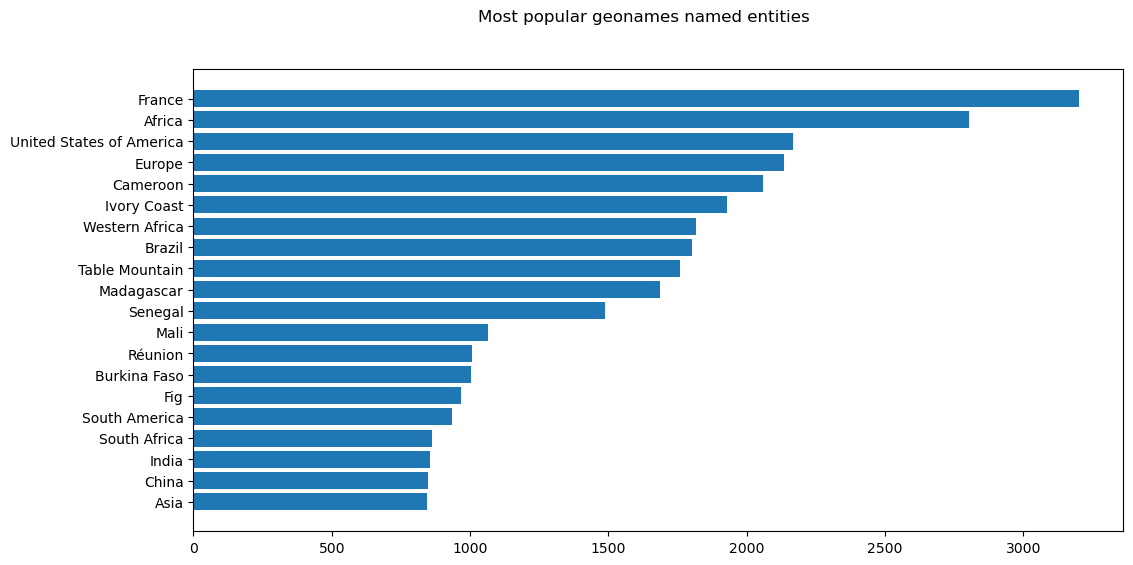

In [104]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle(f'Most popular {vocab} named entities')

plt.barh(df_ne_count[vocab].head(20).entityLabel , width= df_ne_count[vocab].head(20).cnt)
plt.gca().invert_yaxis()

plt.show()

OBSERVATIONS: 
- AGROVOC: top named entities are general concepts
- GEONAMES: as expected 
- WIKIDATA: as expected the top named entities are either geographic or agriculture related.
- DBPEDIA: not as agricultural as wikidata. Odd one: *Seconde Guerre Mondiale*.

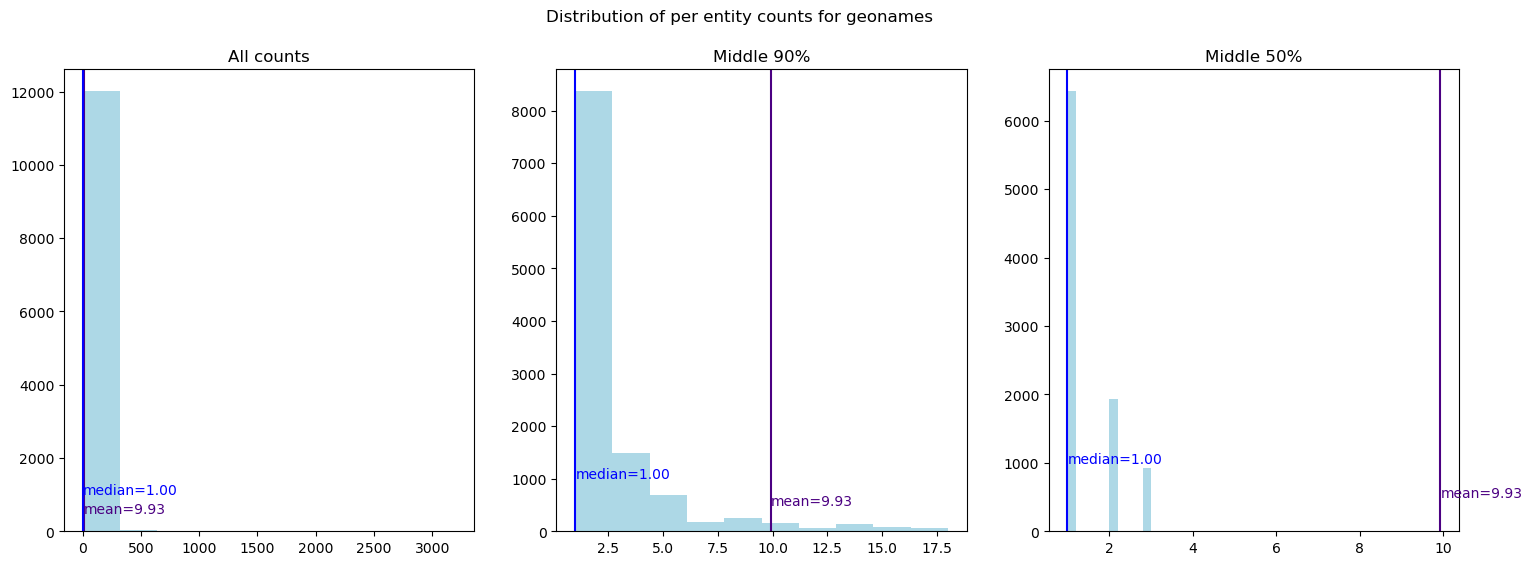

In [105]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle(f'Distribution of per entity counts for {vocab}')

def show_hist(i, df_f1, range=None, title=None):
    mean_cnt = df_f1.cnt.mean()
    median_cnt = df_f1.cnt.median()

    plt.subplot(1 , 3, i+1)

    plt.hist(df_f1.cnt, 10, color='lightblue', range=range )
    plt.axvline(mean_cnt, color='indigo')
    plt.text(mean_cnt + 0.01, 500, 'mean=%.2f' % mean_cnt , color="indigo")

    plt.axvline(median_cnt, color="blue")
    plt.text(median_cnt + 0.01, 1000, 'median=%.2f' % median_cnt , color="blue")
    
    plt.title(title)


show_hist(0, df_ne_count[vocab], title='All counts')
show_hist(1, df_ne_count[vocab], range=(df_ne_count[vocab].cnt.quantile(0.05) ,  
                                        df_ne_count[vocab].cnt.quantile(0.95)),
          title='Middle 90%' )
show_hist(2, df_ne_count[vocab], range=(df_ne_count[vocab].cnt.quantile(0.25) ,
                                        df_ne_count[vocab].cnt.quantile(0.75)),
         title='Middle 50%')

### Missing labels

In [106]:
print(df_ne_count[vocab][df_ne_count[vocab].entityLabel.isna()].shape)

df_ne_count[vocab][df_ne_count[vocab].entityLabel.isna()]\
    .head()\
    .style.format({'uri': hyperlink})

(58, 5)


,uri,entityLabel,cnt,min_conf,max_conf
776,https://sws.geonames.org/8505035/,None,14,0.262600,0.711100
823,https://sws.geonames.org/12264645/,None,13,0.394000,0.395000
873,https://sws.geonames.org/12264110/,None,13,0.448100,0.567300
1498,https://sws.geonames.org/7257747/,None,7,0.383900,0.388300
1543,https://sws.geonames.org/12262019/,None,7,0.653900,0.653900


OBSERVATIONS: 
- AGROVOC: no missing values! :thumbup
- GEONAMES:
- WIKIDATA: investigate why 322 entities do not have labels
- DBPEDIA: Cannot retrieve labels for 28 entities because teh labels are not defined in their respective DBPedia instances.

### Named entities recognised from a short word ( surface <= 3 characters)

In [107]:
short_text_query_templ = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <http://data-issa.cirad.fr/property/> 

SELECT ?surfaceLen ?surface ?entityLabel_en ?entityLabel_fr ?entityLabel ?entityUri ?cnt 
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {
      {SELECT ?surface ?entityUri (count(?surface) as ?cnt) (max(?surfaceLEN) as ?surfaceLen)
      WHERE {
            #VALUES (?entity) {(<http://data-issa.cirad.fr/ann/00006684522793ef568fee34752ac6371f33d3c3>)}
            ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  issapr:confidence ?conf;
                  prov:wasAttributedTo ?annotator.
            FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

            ?selector oa:exact ?surface;
                  oa:start ?start.

            BIND ( STRLEN(?surface) as ?surfaceLEN )
            FILTER ( ?surfaceLEN %s )
            } 
      GROUP BY ?surface ?entityUri ?entityLabel
      }
      OPTIONAL {
            #?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel.
            ?entityUri %s ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }
      OPTIONAL {
            ?entityUri %s ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }
      # for Geonames
      #OPTIONAL {
      #      ?entityUri gn:name ?entityLabel_nolang.
      #}

      BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
}
ORDER BY ?surface ?entityLabel
'''

In [108]:
df_short_text_count = {}

df_short_text_count[vocab] = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                                            short_text_query_templ %  (annotators[vocab], '< 4',
                                                                                       label_path[vocab], label_path[vocab]) )
df_short_text_count[vocab] = df_short_text_count[vocab].astype({'cnt': 'int',
                                                                'surfaceLen': 'int'})
print(annotators[vocab] , df_short_text_count[vocab].shape)

issa:GeographicEntityExtractor (1026, 7)


#### len(surface) == 1

In [109]:
print(df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 1].shape)
df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 1]\
                          .sort_values(by=['entityLabel_en','cnt'])\
                  #.style.set_table_styles(table_style)

(0, 7)


,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt


OBSERVATIONS: 
- AGROVOC: filtering of surface >= 3 in effect :thumbsup
- GEONAMES:
- WIKIDATA:  filtering surface string >= 3 in effect :thumbsup
- DBPEDIA: filtering surface string >= 3 in effect :thumbsup

#### len(surface) == 2

In [110]:
print(df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 2].shape)
df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 2]\
                          .sort_values(by=['entityLabel_en','cnt'])\
                  #.style.format({'entityUri': hyperlink})

(275, 7)


,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
13,2,AL,Alabama,None,Alabama,https://sws.geonames.org/4829764/,23
9,2,AK,Alaska,None,Alaska,https://sws.geonames.org/5879092/,10
29,2,AZ,Arizona,None,Arizona,https://sws.geonames.org/5551752/,1
20,2,AR,Arkansas,None,Arkansas,https://sws.geonames.org/4099753/,58
736,2,RA,Armenia,None,Armenia,https://sws.geonames.org/174982/,9
...,...,...,...,...,...,...,...
693,2,PI,None,None,None,https://sws.geonames.org/3392213/,87
982,2,WB,None,None,None,https://sws.geonames.org/4141143/,98
948,2,VI,None,Vicence,Vicence,https://sws.geonames.org/3164418/,131
63,2,BC,None,None,None,https://sws.geonames.org/5909050/,172


CONCLUSION: 
- AGROVOC: the 2 letter surface also does not match very well with the exceptions of UK, EU, and pH. I think they should be filtered as well (0.4% of all) => filtering surface string >= 3 in effect
- GEONAMES: hard to tell, some of the 2 letter entities look ok, like *UK* or *US* but some are quesionable like *LA* or *SC*. Removing these entities would mean removing 4% of annottaions. Definetely needs a closer look.
- WIKIDATA: filtering surface string >= 3 is in effect :thimbsup
- DBPEDIA: filtering surface string >= 3 is in effect :thimbsup

#### len(surface) == 3

In [111]:
pd.options.display.max_rows = 100
df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 3]\
                          .sort_values(by=['cnt', 'entityLabel_en'], ascending=False)\
               .head()
               #.style.format({'entityUri': hyperlink})


,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
297,3,Fig,None,None,None,https://sws.geonames.org/4466155/,2533
926,3,USA,United States of America,États-Unis,United States of America,https://sws.geonames.org/6252001/,1679
503,3,Les,None,None,None,https://sws.geonames.org/6362989/,1580
244,3,EUR,None,None,None,https://sws.geonames.org/6269270/,487
83,3,BJA,None,Béjaïa,Béjaïa,https://sws.geonames.org/2505329/,440


OBSERVATIONS: 
- AGROVOC: for the populous 3 letter words the annotation is pretty accurate. For less popular words and abbreviations it's hard to tell without the context
- GEONAMES:
- WIKIDATA: hard to tell. some of the 3 letter entities look ok, like *CWD* (Coffee Wilt Disease). Definetely needs a closer look.
- DBPEDIA: hard to tell. some of the 3 letter entities look ok, like *USA* (United States) or *DNA*.  

### Surface forms that begin with non-letters

In [112]:
text_starts_with_non_letter_query_templ = ''' 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <http://data-issa.cirad.fr/property/> 

SELECT ?surfaceLen ?surface ?entityLabel_en ?entityLabel_fr ?entityLabel ?entityUri ?cnt 
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {
      {SELECT ?surface ?entityUri (count(?surface) as ?cnt) (max(?surfaceLEN) as ?surfaceLen)
      WHERE {
            #VALUES (?entity) {(<http://data-issa.cirad.fr/ann/00006684522793ef568fee34752ac6371f33d3c3>)}
            ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  issapr:confidence ?conf;
                  prov:wasAttributedTo ?annotator.
            FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

            ?selector oa:exact ?surface;
                  oa:start ?start.

            BIND ( STRLEN(?surface) as ?surfaceLEN )
            FILTER ( ! REGEX(?surface, "^[a-z,A-Z,À-ÿ]")  ) # Greek letters ,\\p{Greek},µ
            } 
      GROUP BY ?surface ?entityUri ?entityLabel
      }
      OPTIONAL {
            #?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel.
            ?entityUri %s ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }
      OPTIONAL {
            ?entityUri %s ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }
      # for Geonames
      OPTIONAL {
            ?entityUri gn:name ?entityLabel_nolang.
      }

      BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
}
ORDER BY ?surface ?entityLabel
'''

In [113]:
df_non_letter_count = {}

df_non_letter_count[vocab] = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                                            text_starts_with_non_letter_query_templ %  (annotators[vocab],
                                                                                       label_path[vocab], label_path[vocab]) )
df_non_letter_count[vocab] = df_non_letter_count[vocab].astype({'cnt': 'int',
                                                                'surfaceLen': 'int'})
print(annotators[vocab] , df_non_letter_count[vocab].shape)

issa:GeographicEntityExtractor (0, 7)


In [114]:
df_non_letter_count[vocab].sort_values(by=['surface'])\
                  #.style.format({'entityUri': hyperlink})
                  

,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt


OBSERVATIONS:
- AGROVOC: filtering in effect 
- GEONAMES: 24 surface forms that start with various non-alphabetical and non-digit characters. Some of the annotations look ok though but the offsets are incorrect. Si I think it would be better to filter them out too and we will not loose much of the information.
- WIKIDATA: filtering out of non-letters beginings of the text is in effect in most part. We should add a curly bracket to the set of non-alphabet characters. But the unit entities taht begin with  µ should stay.
- DBPEDIA: filtering out of non-letters beginings of the text is in effect



### Multiple named entities for one surface form

In [115]:
multiple_entities_query_templ = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>


SELECT ?source ?surface ?start ?cnt 
       #?entities 
WHERE {
  { SELECT ?source ?surface ?start 
          (count(?entityUri) as ?cnt)
          (group_concat(?entityUri; separator=", ") as ?entities) 
    WHERE {
          #VALUES (?entity) {(<http://data-issa.cirad.fr/ann/00006684522793ef568fee34752ac6371f33d3c3>)}
          ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  prov:wasAttributedTo ?annotator.
          FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

          ?selector oa:exact ?surface;
                    oa:start ?start.
          } 
    GROUP BY ?source ?surface ?start
    HAVING ((count(?entityUri) %s ) )
  }

}
order by desc(?cnt)
'''

In [116]:
pd.options.display.max_colwidth = 100

df_multi_entities = df_multi_entities if 'df_multi_entities' in locals() else {}

df_multi_entities[vocab] = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                                        multiple_entities_query_templ %  (annotators[vocab], '> 1') )

df_multi_entities[vocab] = df_multi_entities[vocab].astype({'cnt': 'int'})

print(annotators[vocab] , df_multi_entities[vocab].shape)

issa:GeographicEntityExtractor (0, 4)


In [117]:
pd.options.display.max_rows = 10
df_multi_entities[vocab].sort_values(by=['cnt'], ascending=False)\
                        #.head()

,source,surface,start,cnt


OBSERVATIONS: 
- AGROVOC: The number of overlaping entities has been reduced by 10 folds by the new vesrion of pyclinrec. However, the problem with multuple entities for the surfaces with repetitive words still persist although to a lesser scale. More analysuis in the next few cells
- GEONAMES: no multiple NEs for the same surface form :thumbsup
- WIKIDATA: no multiple NEs for the same surface form :thumbsup
- DBPEDIA: no multiple NEs for the same surface form :thumbsup

#### detect repeated text 

Sometimes repeated string in the surface form creates multiple NEs

In [118]:
def detect_repeat(string_to_split):
    import re
    return pd.Series(re.split('-| ', string_to_split.lower())).value_counts().max() > 1

df_multi_entities[vocab]['repeat']  = df_multi_entities[vocab].surface.apply(detect_repeat)


df_multi_entities[vocab].loc[df_multi_entities[vocab].repeat]\
                        .sort_values(by=['cnt', 'surface'], ascending=False)\
                        .head()\
                        #.style.format({'source': hyperlink})

,source,surface,start,cnt,repeat


In [119]:
# non repeated text
pd.options.display.max_rows = 10
df_multi_entities[vocab].loc[df_multi_entities[vocab].repeat==False]\
                        .sort_values(by=['cnt', 'surface'], ascending=False)\
                        .head()\
                        #.style.format({'source': hyperlink})

,source,surface,start,cnt,repeat


In [120]:
# Complementary query: get all the entities for a specific text

entities_for_surface_query_templ = ''' 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <http://data-issa.cirad.fr/property/> 

SELECT ?source ?start ?surface ?entityUri ?entityLabel_en ?entityLabel_fr
WHERE 
{
    VALUES (?source) {(<%s>)}
    VALUES (?start) {(%d)}
    
    ?entity a prov:Entity;
            oa:hasBody ?entityUri;       
            oa:hasTarget/oa:hasSelector ?selector;
            oa:hasTarget/oa:hasSource ?source;
            prov:wasAttributedTo ?annotator.
    FILTER (?annotator = %s)

    ?selector oa:exact ?surface;
              oa:start ?start.

    OPTIONAL {
        ?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel_en.
        FILTER langMatches(lang(?entityLabel_en), "en" )  }

	OPTIONAL {
	    ?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel_fr.
        FILTER langMatches(lang(?entityLabel_fr), "fr" ) }
}
'''

# copy/paste the values for this query here: 
source = 'http://data-issa.cirad.fr/document/593761#body_text'
start  = 655

df_nes = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                    entities_for_surface_query_templ %  (source, start, annotators[vocab]) )
print(df_nes.shape)
df_nes

(0, 6)


,source,start,surface,entityUri,entityLabel_en,entityLabel_fr


### Overlaping Named Entities

In [121]:
overlaping_na_query_templ  = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX issapr: <http://data-issa.cirad.fr/property/> 

select ?source ?surface ?start ?end ?conf ?entityUri
               ?surface_ovlp ?start_ovlp ?conf_ovlp ?entityUri_ovlp
WHERE 
{
  {
    SELECT distinct ?annotator ?source ?surface ?start ?end ?conf ?entityUri
    WHERE {
      ?entity a prov:Entity;
              oa:hasBody ?entityUri; 
              oa:hasTarget/oa:hasSelector ?selector;
              oa:hasTarget/oa:hasSource ?source;
              issapr:confidence ?conf;
              prov:wasAttributedTo ?annotator.
      FILTER (?annotator = %s ) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

      ?selector oa:exact ?surface;
                        oa:start ?start.
      OPTIONAL { ?selector oa:end ?end_opt. }
      BIND( COALESCE( ?end_, ?start + STRLEN(?surface)) AS ?end)

      FILTER(REGEX(?surface, "\\\\w+\\\\s+\\\\w+", "i")) # 2 or more words
      #FILTER(REGEX(?surface, "\\\\w+\\\\s+\\\\w+(\\\\s+\\\\w+)+", "i")) # 3 or more words
    }
    OFFSET %d
    LIMIT %d
  }
	?entity_ovlp a prov:Entity;
              oa:hasBody ?entityUri_ovlp;       
              oa:hasTarget/oa:hasSelector ?selector_ovlp;
              oa:hasTarget/oa:hasSource ?source;
              issapr:confidence ?conf_ovlp;
              prov:wasAttributedTo ?annotator.

      ?selector_ovlp  oa:exact ?surface_ovlp;
    					oa:start ?start_ovlp.
      OPTIONAL { ?selector_ovlp oa:end ?end_opt_ovlp. } #this is important for wikidata
      BIND( COALESCE( ?end_opt_ovlp, ?start_ovlp + STRLEN(?surface_ovlp)) AS ?end_ovlp) 
                        
      FILTER ( ((?start_ovlp > ?start) && (?start_ovlp < ?end) ) ||
               ((?start_ovlp = ?start) && (?end_ovlp   < ?end)) )
}
'''

In [122]:
df_overlaping_ne = {}

df_overlaping_ne[vocab] = sparql_service_to_dataframe_with_scrollable_cursor(issa_agritrop_endpoint,
                                                                             overlaping_na_query_templ,
                                                                             (annotators[vocab], ),
                                                                             page_size = 5000)
df_overlaping_ne[vocab].shape

fetching... 0


(0, 0)

In [123]:
df_overlaping_ne[vocab]

""


In [124]:
df_overlaping_ne[vocab].groupby(by=['surface', 'surface_ovlp'])\
                       .count()\
                       .sort_values(by='source', ascending=False )\
                       .loc[:, ['source', 'start', 'end' ]]

KeyError: 'surface'

In [ ]:
df_overlaping_ne[vocab].groupby(by=['source'])\
                       .count()\
                       .sort_values(by='surface', ascending=False )\
                       .loc[:, ['surface', 'start', 'end' ]]

#### starts with

In [ ]:
starts_with = df_overlaping_ne[vocab].loc[df_overlaping_ne[vocab]\
                                     .apply(lambda r: r.surface.startswith(r.surface_ovlp), axis=1)]

print(starts_with.shape )
starts_with.head()

#### ends with

In [ ]:
ends_with = df_overlaping_ne[vocab].loc[df_overlaping_ne[vocab]\
                                   .apply(lambda r: r.surface.endswith(r.surface_ovlp), axis=1)]

print(ends_with.shape )
ends_with.head()

#### contains

In [ ]:
contains = df_overlaping_ne[vocab].loc[df_overlaping_ne[vocab]\
                                  .apply(lambda r: r.surface_ovlp in r.surface[1:-1], axis=1)]

print(contains.shape )
contains.head()

#### partial overlap

In [ ]:
partial_overlap = df_overlaping_ne[vocab].loc[df_overlaping_ne[vocab]\
                                        .apply(lambda r: r.surface_ovlp not in r.surface, axis=1)]

print(partial_overlap.shape )
partial_overlap.head()

OBSERVATIONS:

- AGROVOC: pyclinrec recognise named entities in overlaping surface forms. All combinations are detected: the same begining, the same ending, one annotated text inside the other, or partially overlap.  
- GEONAMES: no overalping :thumbsup
- WIKIDATA: no overalping :thumbsup
- DBPEDIA: DBPedia spotlight recognise named entities in overlaping surface forms. All combinations are detected: the same begining, the same ending, one annotated text inside the other, or partially overlap.   